### Import Libraries

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#for fuzzy feature
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pickle

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### load datasets

In [3]:
df_initial = pd.read_csv("/content/drive/MyDrive/duplicate questions predictions/data/questions.csv")
df_initial.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df_initial.shape

(404290, 6)

In [5]:
df = df_initial.sample(30000,random_state=2)

In [6]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [7]:
df.dropna(inplace = True)

In [8]:
df.duplicated().sum()

0

In [9]:
df["is_duplicate"].value_counts()

0    19013
1    10987
Name: is_duplicate, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 398782 to 312470
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.6+ MB


### Data Preprocessing & EDA

In [11]:
def preprocess(sentence):
    
    sentence = str(sentence).lower().strip()
    
    # Replace certain special characters with their string equivalents
    sentence = sentence.replace('%', ' percent')
    sentence = sentence.replace('$', ' dollar ')
    sentence = sentence.replace('₹', ' rupee ')
    sentence = sentence.replace('€', ' euro ')
    sentence = sentence.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    sentence = sentence.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    sentence = sentence.replace(',000,000,000 ', 'b ')
    sentence = sentence.replace(',000,000 ', 'm ')
    sentence = sentence.replace(',000 ', 'k ')
    sentence = re.sub(r'([0-9]+)000000000', r'\1b', sentence)
    sentence = re.sub(r'([0-9]+)000000', r'\1m', sentence)
    sentence = re.sub(r'([0-9]+)000', r'\1k', sentence)  

    # Removing HTML tags
    sentence = BeautifulSoup(sentence)
    sentence = sentence.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    sentence = re.sub(pattern, ' ', sentence).strip()

    return sentence

In [12]:
df["question1"] = df["question1"].apply(preprocess)
df["question2"] = df["question2"].apply(preprocess)

In [13]:
#decontracting words
contractions_dict = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def decontracted(s, contractions_dict=contractions_dict):
     def replace(match):
         return contractions_dict[match.group(0)]
     return contractions_re.sub(replace, s)

In [14]:
df["question1"] = df["question1"].apply(decontracted)
df["question2"] = df["question2"].apply(decontracted)

In [15]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0
244531,244531,145041,264664,i killed a snake on a friday there s a belief...,do snakes really take revenge,0
16633,16633,31698,31699,is the royal family a net gain or a net loss t...,why does the british royal family think it s o...,0
396316,396316,529365,529366,if a huge asteroid was about to hit earth in x...,a 100 mile wide asteroid is projected to hit e...,0
399493,399493,532771,456968,what would happen if a woman took viagra,does viagra really work,0
15268,15268,29183,29184,how could i improve my love to my girlfriend,how do i improve my relationship with my girlf...,0


In [16]:
# Distribution of duplicate and non-duplicate questions
print(f"number of non-duplicate questions: {df.is_duplicate.value_counts()[0]}")
print(f"number of duplicate questions: {df.is_duplicate.value_counts()[1]}")

number of non-duplicate questions: 19013
number of duplicate questions: 10987


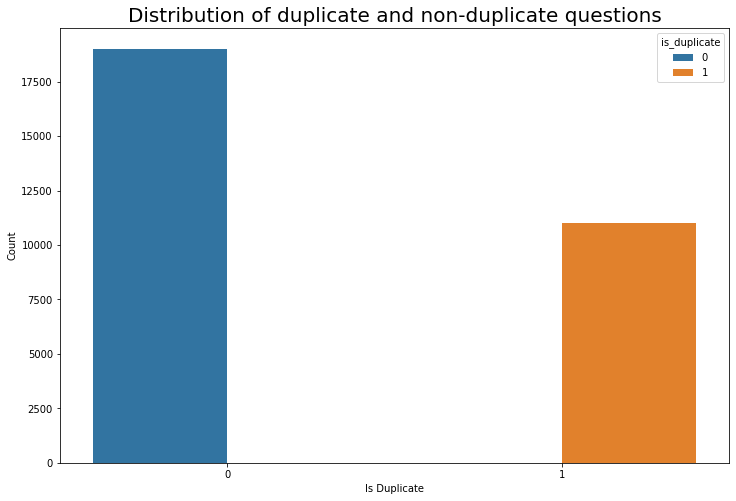

In [17]:
# Histogram of duplicate and non-duplicate questions
plt.figure(figsize=(12,8))
sns.countplot(x = df["is_duplicate"], hue = df["is_duplicate"])
plt.title("Distribution of duplicate and non-duplicate questions", size=20)
plt.xlabel("Is Duplicate", size=10)
plt.ylabel("Count", size=10)
plt.show()

In [18]:
# Repeated questions
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 55299
Number of questions getting repeated 3480


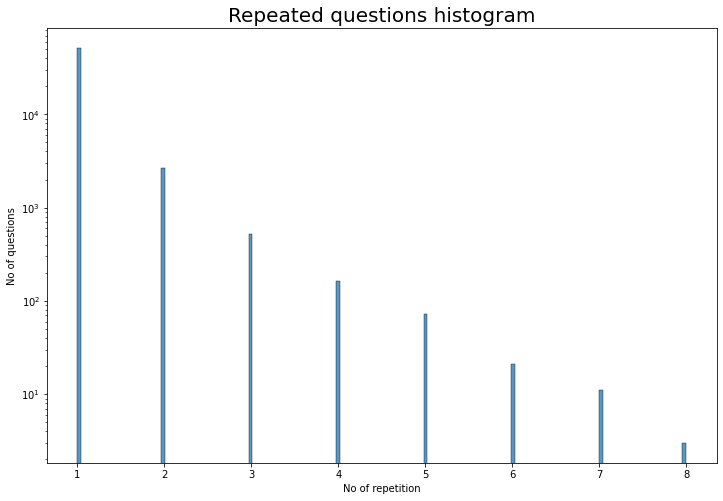

In [19]:
# Repeated questions histogram
plt.figure(figsize=(12,8))
sns.histplot(qid.value_counts().values,bins=160)
plt.title("Repeated questions histogram", size=20)
plt.xlabel("No of repetition")
plt.ylabel("No of questions")
plt.yscale('log')
plt.show()

### Feature Engineering

In [20]:
#length of each questions
df['len_q1'] = df['question1'].str.len() 
df['len_q2'] = df['question2'].str.len()
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49


In [21]:
#number of words in each questions
df['num_words_q1'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['num_words_q2'] = df['question2'].apply(lambda row: len(row.split(" ")))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9


In [22]:
#common words between question1 and question2
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

df["common_words"] = df.apply(common_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3


In [23]:
#total number of  words in two questions
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

df['total_words'] = df.apply(total_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words,total_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13


In [24]:
#word share
df['word_share'] = round(df['common_words']/df['total_words'],2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words,total_words,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


minimum characters 2
maximum characters 397
average num of characters 58


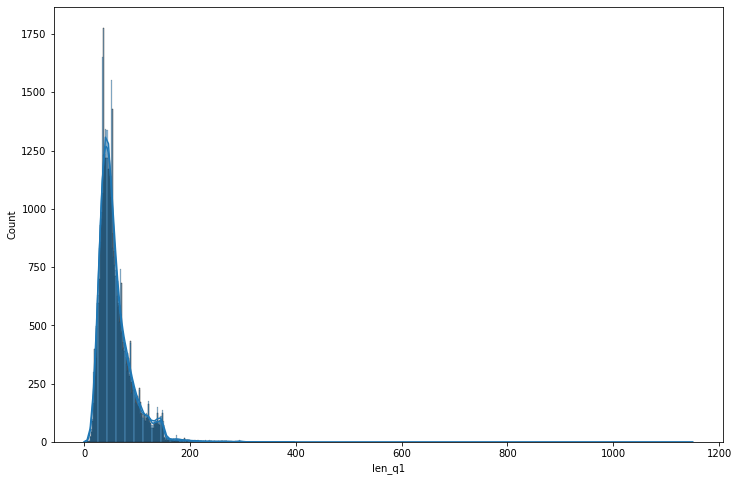

In [25]:
# Analysis of features
print('minimum characters',df['len_q1'].min())
print('maximum characters',df['len_q1'].max())
print('average num of characters',int(df['len_q1'].mean()))

plt.figure(figsize=(12,8))
sns.histplot(df['len_q1'], kde=True)
sns.histplot(df['len_q2'], kde=True)
plt.show()

minimum characters 0
maximum characters 1150
average num of characters 59


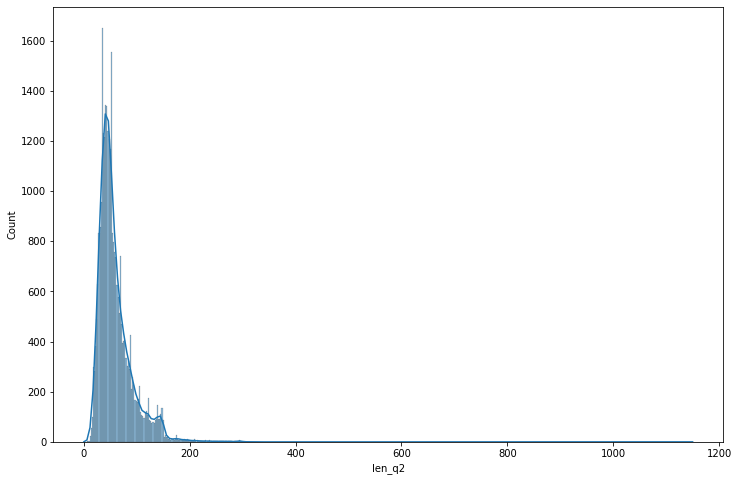

In [26]:
print('minimum characters',df['len_q2'].min())
print('maximum characters',df['len_q2'].max())
print('average num of characters',int(df['len_q2'].mean()))

plt.figure(figsize=(12,8))
sns.histplot(df['len_q2'], kde=True)
plt.show()

minimum words 1
maximum words 79
average num of words 11


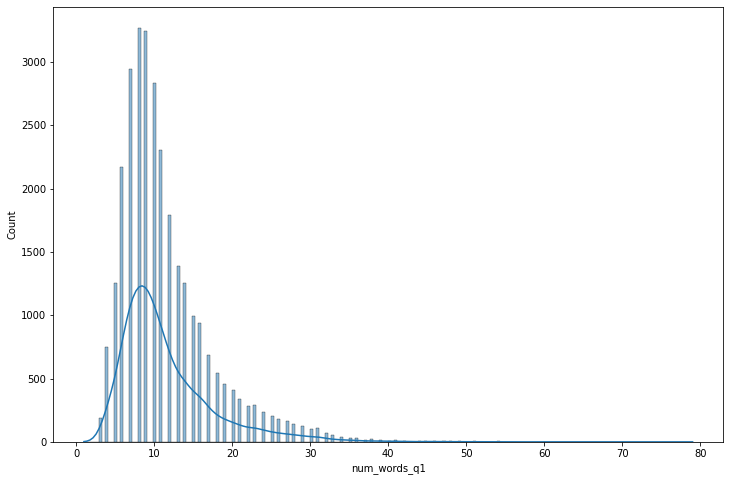

In [27]:
print('minimum words',df['num_words_q1'].min())
print('maximum words',df['num_words_q1'].max())
print('average num of words',int(df['num_words_q1'].mean()))

plt.figure(figsize=(12,8))
sns.histplot(df['num_words_q1'], kde=True)
plt.show()

minimum words 1
maximum words 270
average num of words 11


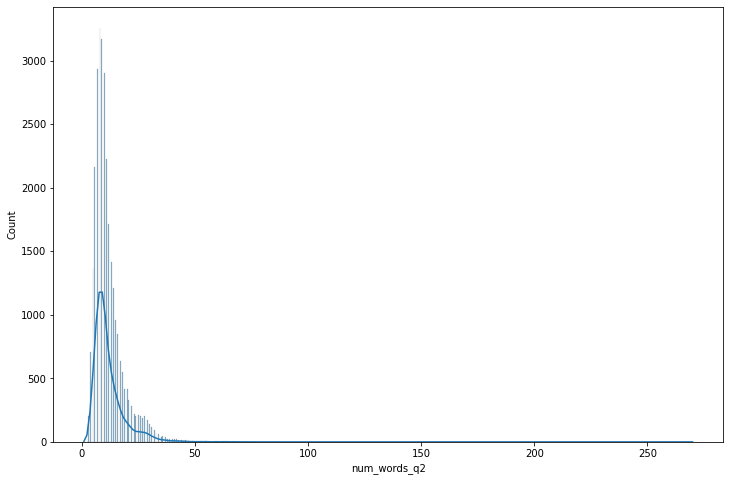

In [28]:
print('minimum words',df['num_words_q2'].min())
print('maximum words',df['num_words_q2'].max())
print('average num of words',int(df['num_words_q2'].mean()))

plt.figure(figsize=(12,8))
sns.histplot(df['num_words_q2'], kde=True)
plt.show()

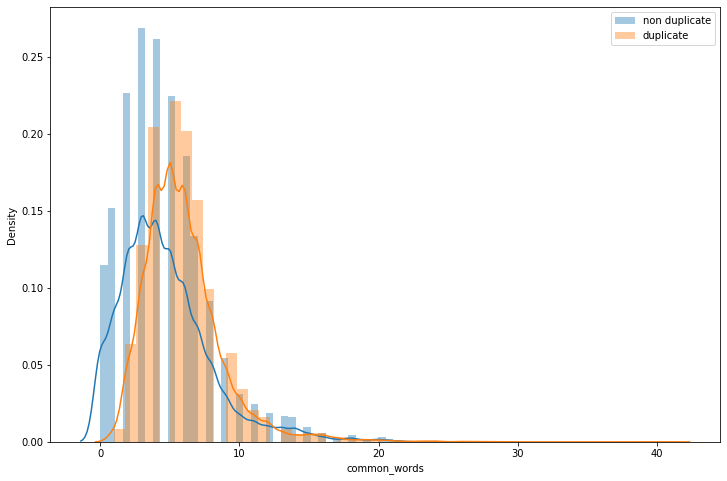

In [29]:
# common words
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 0]['common_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['common_words'],label='duplicate')
plt.legend()
plt.show()

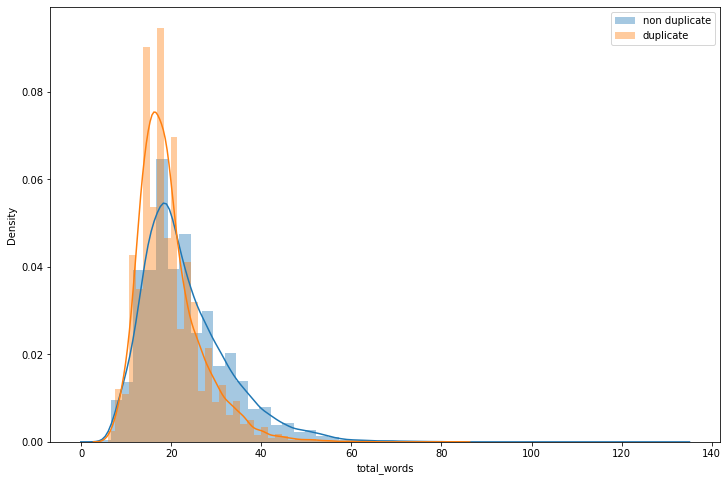

In [30]:
# total words
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 0]['total_words'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['total_words'],label='duplicate')
plt.legend()
plt.show()

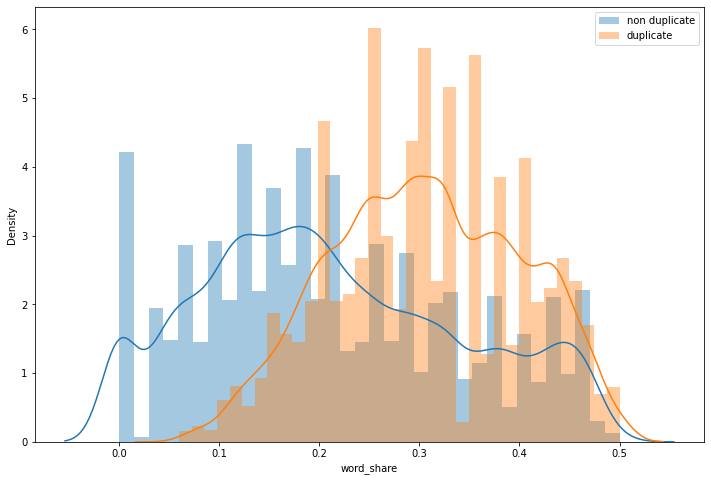

In [31]:
# word share
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

## Advanced Features
**1. Token Features**
* **cwc_min**: This is the ratio of the number of common words to the length of the smaller question
* **cwc_max**: This is the ratio of the number of common words to the length of the larger question
* **csc_min**: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
* **csc_max**: This is the ratio of the number of common stop words to the larger stop word count among the two questions
* **ctc_min**: This is the ratio of the number of common tokens to the smaller token count among the two questions
* **ctc_max**: This is the ratio of the number of common tokens to the larger token count among the two questions
* **last_word_eq**: 1 if the last word in the two questions is same, 0 otherwise
* **first_word_eq**: 1 if the first word in the two questions is same, 0 otherwise

**2. Length Based Features**
* **mean_len**: Mean of the length of the two questions (number of words)
* **abs_len_diff**: Absolute difference between the length of the two questions (number of words)

**3. Fuzzy Features**
* **fuzz_ratio**: fuzz_ratio score from fuzzywuzzy
* **fuzz_partial_ratio**: fuzz_partial_ratio from fuzzywuzzy
* **token_sort_ratio**: token_sort_ratio from fuzzywuzzy
* **token_set_ratio**: token_set_ratio from fuzzywuzzy

In [32]:
#token feature
def fetch_token_features(df):
    q1 = df['question1']
    q2 = df['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [33]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [34]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,...,total_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,26,0.46,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,24,0.33,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,38,0.11,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,34,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0


In [35]:
#length based feature
def fetch_length_features(row):
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*2
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    return length_features

In [36]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))

In [37]:
# Fuzzy Features
def fetch_fuzzy_features(row):  
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [38]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

print(df.shape)
df.head()

(30000, 27)


,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.923070,0.923070,1.0,1.0,0.0,13.0,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.583328,0.466664,1.0,1.0,3.0,13.5,69,67,65,74
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.149999,0.115384,0.0,0.0,6.0,23.0,26,29,34,43
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.000000,0.0,0.0,17.0,21.5,29,41,23,30
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.599988,0.333330,1.0,0.0,4.0,7.0,55,70,48,69


### advanced feature analysis

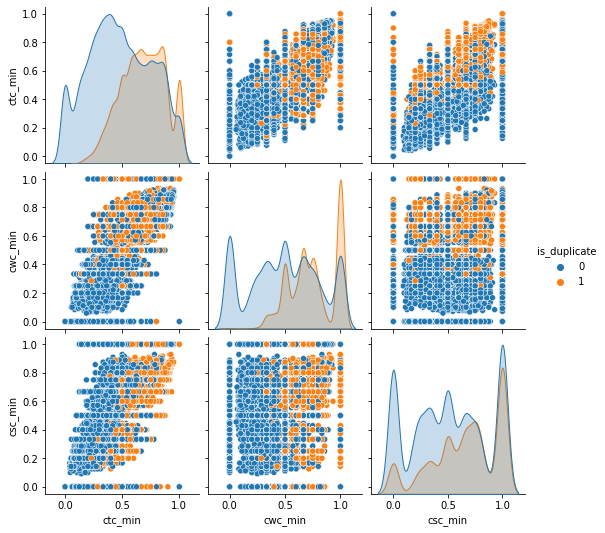

In [39]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')
plt.show()

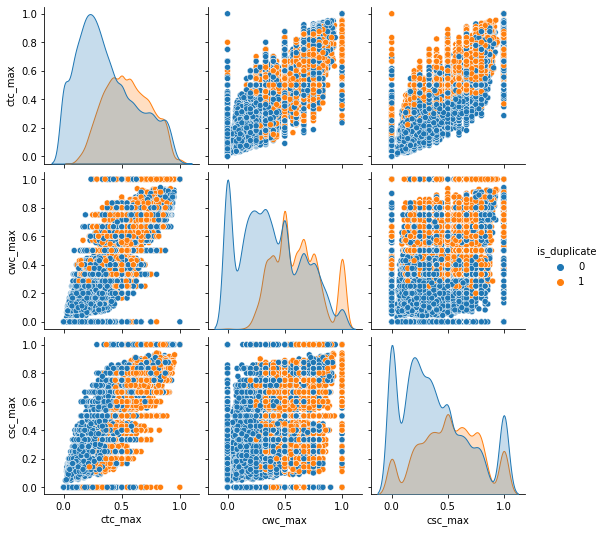

In [40]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')
plt.show()

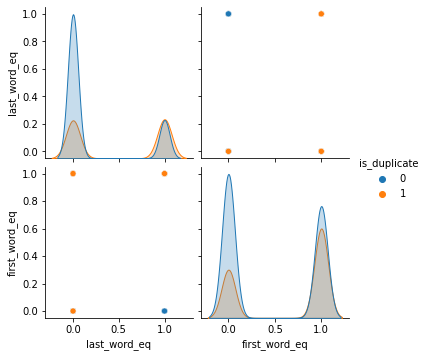

In [41]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')
plt.show()

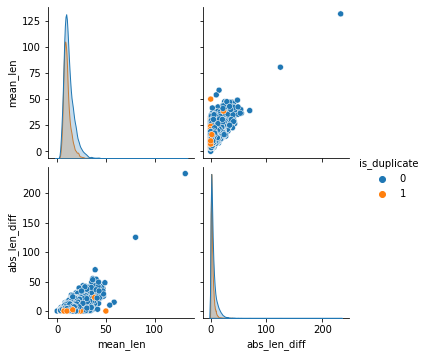

In [42]:
sns.pairplot(df[['mean_len', 'abs_len_diff', 'is_duplicate']],hue='is_duplicate')
plt.show()

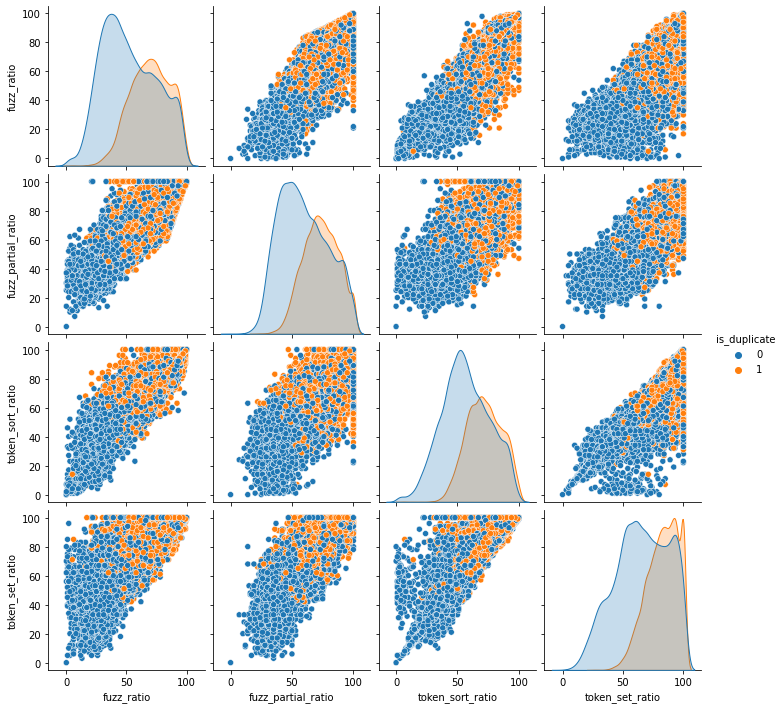

In [43]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'is_duplicate']],hue='is_duplicate')
plt.show()

In [44]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


In [45]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 22)


,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words,total_words,word_share,cwc_min,cwc_max,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.923070,0.923070,1.0,1.0,0.0,13.0,99,99,99,99
115086,0,48,56,13,16,8,24,0.33,0.666644,0.499988,...,0.583328,0.466664,1.0,1.0,3.0,13.5,69,67,65,74
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0.149999,0.115384,0.0,0.0,6.0,23.0,26,29,34,43
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,17.0,21.5,29,41,23,30
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.599988,0.333330,1.0,0.0,4.0,7.0,55,70,48,69


In [46]:
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=1000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [47]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 2000)

In [48]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 2022)


,is_duplicate,len_q1,len_q2,num_words_q1,num_words_q2,common_words,total_words,word_share,cwc_min,cwc_max,...,990,991,992,993,994,995,996,997,998,999
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0,0,0,0,0,0,0,0,0,0
115086,0,48,56,13,16,8,24,0.33,0.666644,0.499988,...,0,0,0,0,0,0,0,0,0,0
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


## model building & training

In [49]:
X = final_df.iloc[:,1:].values
y = final_df.iloc[:,0].values

In [50]:
#splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [51]:
#using random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy_score(y_pred, y_test)

0.782

In [52]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[3213,  552],
       [ 756, 1479]])

In [53]:
#using XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

accuracy_score(y_pred, y_test)

0.7523333333333333

In [54]:
# for XGBClassifier
confusion_matrix(y_test,y_pred)

array([[3140,  625],
       [ 861, 1374]])

### predictions

In [55]:
#function to return common words for given questions
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

#function to return total words of given questions
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))


#for token features
def test_fetch_token_features(q1,q2): 
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


#for length features
def test_fetch_length_features(q1,q2):
    length_features = [0.0]*2
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    return length_features


#for fuzzy features
def test_fetch_fuzzy_features(q1,q2):
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [56]:
def query_point_creator(q1,q2):
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)

    #decontracted
    q1 = decontracted(q1)
    q2 = decontracted(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    return np.hstack((np.array(input_query).reshape(1,21),q1_bow,q2_bow))

In [57]:
q1 = 'who is the prime minister of Nepal?'
q2 = 'who is the current prime minister of Nepal?'

In [58]:
rf.predict(query_point_creator(q1,q2))

array([1])

In [61]:
STOP_WORDS = stopwords.words("english")

In [62]:
pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))
pickle.dump(STOP_WORDS, open('STOP_WORDS.pkl', 'wb'))